# Burnwire Experimentation
### Background
The deployable antenna systems are stowed with potential energy stored in compression and torsion springs.  A monofilament line prevents the antennas from deploying until a signal is received.  Current is fed through a resistive element which will heat up the monofilament past its glass transition temperature at which will cause the line to fail in tension, releasing the springs.  

The monofilament will be wound around the resistive element which itself will be soldered to a PCB.  The designed steady state temperature of the resistive element should lie between the melting temperature of the solder and the glass transition temperature of the monofilament.  

### Steady State Temperature
In order to determine the steady state temperature of a resistive element we will use the **Stephan-Boltzmann Law** to describe the power flux in terms of temperature and emissivity.

$$ j^* = \epsilon \sigma T^4 $$

The power flux can also be represented as power dissipated over the resistive element's surface area.

$$ j^* = \frac{P}{A} $$

The two can be related:

$$ \epsilon \sigma T^4 = \frac{P}{A_S} $$

where $ P = \frac{V^2}{R} = I^2 R $

$$ \epsilon \sigma T^4 = \frac{V^2}{RA_S} = \frac{I^2 R}{A_S} $$

and $ R = \frac{\rho l }{ A_C }$

$$ \epsilon \sigma T^4 = \frac{V^2 A_C}{\rho l A_S} = \frac{I^2 \rho l}{A_C A_S} $$

where $ A_C = \pi r^2 $ and $ A_S = 2 \pi r l $

$$ \epsilon \sigma T^4 = \frac{V^2 r}{2 \rho l^2} = \frac{I^2 \rho}{2 \pi^2 r^3} $$

Rearranging the equation for temperature,

$$ T = \sqrt[4]{\frac{V^2 r}{2 \epsilon \sigma \rho l^2}} = \sqrt[4]{\frac{I^2 \rho}{2 \epsilon \sigma \pi^2 r^3}} $$

With extreme fluctuations in the ambient temperature, the target steady state temperature of the resistive element must err towards higher values which will increase the risk of melting the solder.  However, in a micro-gravity environment the dynamics of the melted solder would be controlled by surface tension which ought to prevent spread of any conductive contamination.  

Monofilament melts at around 250 degrees C.  Solder melts somewhere around 450 degrees C.  The ambient temperature will be somewhere between -50 and +150 degrees C.  This means that at a target temperature of 300 degrees C we will barely melt the monofilament in the coldest conditions and nearly melt the solder in the hotest conditions.  (*These values are super average and should not be used in any real calculations.*)   

We will be using a bare LiPo battery cell with no voltage regulation.  However, over the course of a single experiment the supply voltage will not change appreciably. The resistive element of choice is nichrome wire.  The following nominal values are used for pre-experimental analysis:

* Voltage: $ V = 3 $ to $ 4.2\ V $
* Resistivity: $ \rho = 1.0 \times 10^{-6} $ to $ 1.5 \times 10^{-6}\ \Omega m $
* Emissivity: $ \epsilon = 0.65 $ to $ 0.79 $
* Stephan-Boltzmann Constant: $ \sigma = 5.67 \times 10^{-8}\ Wm^{-2}K^{-4} $

Note that these values will stray from theory as the equations rely on a few key assumptions:
- The voltage drop across the nichrome is constant over time
- The resistivity of the nichrome does not change appreciably as the temperature rises
- The length of the nichrome does not grow appreciably as the temperature rises

These assumptions are not too egregious.  With a coefficient of linear expansion of 0.000017, a typical wire will not elongate more than 100 microns.  The resistivity increases by a mere 7.8% at the upper end of the material's recommended operating temperature (~1100 degrees C).  A proportionally small change in current (according to Ohm's law) is similarly negligible for the purposes of this model. (Material properties taken from [Omega](https://www.omega.com/temperature/pdf/NI80.pdf).)

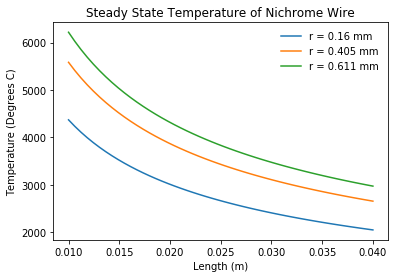

In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt

V = (3.5 + 4.2)/2
rho = (1.0e-6 + 1.5e-6)/2
epsilon = (0.65 + 0.79)/2
sigma = 5.67e-8

r = np.r_[0.160, 0.405, 0.611] / 1000 # Standard AWG Sizes (m)
l = np.linspace(0.01, 0.04)

for radius in r:
    T = np.power(((V**2*radius*2)/(2*epsilon*sigma*rho*l**2)), 1/4) - 272.15
    plt.plot(l, T, label = "r = {} mm".format(str(1000*radius)))

plt.legend(loc='upper right', frameon=False)
plt.title("Steady State Temperature of Nichrome Wire")
plt.xlabel("Length (m)")
plt.ylabel("Temperature (Degrees C)")
plt.show()

**Figure 1**: Steady state temperature of a nichrome resistive element as a function of length and radius.

These theoretical temperature values are far greater than the upper end of the operating range (~1100 degrees C) and even beyond the melting point of nichrome (~1400 degrees C).  This implies that the nichrome wire would burn out like a fuse.  This should not be a problem - if the resistive element reaches that high of a temperature then it will necessarily pass the glass transition temperature of the monofilament.  However, if the nichrome heated up at a sufficiently quick rate, then it might not transfer enough heat to cause a failure in the monofilament.  

### Heat Rate

Dr. Gerald Recktenwald did some basic theoretical analysis of the heat rate of nichrome wire.  His results are in a LaTeX document on the Google Drive.

### Measurements

Calculations for theoretical values are simple but they rely on the assumptions of a lumped parameter model.  Measuring the actual temperature of the resistive element is a meaningful exercise for this essential system.  

The broader purpose of this experiment is to estimate the reliability of the burnwire system.  A successful burn occurs when the resistive element heats the monofilament to failure in a reasonable time and without using too much energy.  There are a number of parameters which we might measure:

* The temperature of the resistive element.  By measuring we will change the value but this shouldn't be an issue; the element will heat at the same rate - it will simply be a lower temperature.  This can be achieved by thermally pasting a thermocouple onto an end of the resistive element.
* The supply voltage provided by the battery.  An initial measurement will be needed in order to analyze the circuit - successive measurements will provide a look into how rapidly the supply voltage drops during an experiment.  
* The current draw on the battery.  As the resistive element heats up it will undergo a nominal change in resistance.  As the battery drains its voltage will decrease.  Other real-world effects will change the amount of current that is actually being drawn from the battery and we will want to monitor this in order measure the total energy used.  This can be achieved by measuring the voltage drop across a Kelvin connection on the shunt resistor.
* The time it takes to sever the monofilament.  A microcontroller should be timing the experiment and therefore needs a way to precisely stop the timer.  This can be achieved by using a metallic spring to close a circuit when it becomes unloaded, or by breaking an IR beam in a simple sensor.

An Arduino will regulate the experimental setup.  It will switch the main circuit using a P-channel MOSFET (with an R_DS(on) below 10 milli-ohms) with a pullup resistor.  Sending a high GPIO signal will close the circuit - this could cause issues with accidental triggering when assembling the circuit, so an inline physical switch might be warranted.  

![circuit.png](circuit.png)
<div style="text-align: center"><b>Figure 2</b>: A schematic of the experimental circuit.</div>

*Note: A better experimental setup would include an op-amp to amplify the shunt resistor's signal to a broader range of the Arduino's 5 V input.*

The shunt resistor, used to generate a voltage drop (which provides a measurement of the current), will affect the rest of the circuit.  With a minor voltage drop, it will decrease the voltage drop seen by the resistive element and consume some power.

### Design of Experiment
Three factors will be controlled in the experimental design:
* Ambient Pressure
* Nichrome Diameter
* Monofilament Diameter

In [38]:
from tabulate import tabulate

factors = [ \
{'Factor': 'Pressure (kPa)', '-1': 16.67, '+1': 101.325}, \
{'Factor': 'Monofilament Diameter (mm)', '-1': 0.37, '+1': 0.70}, \
{'Factor': 'Nichrome Diameter (mm)', '-1': 0.160, '+1': 0.644}]

levels = list(factors[0].keys())[1:]
K = len(levels)
k = len(factors)
runs = 2**k

headers = list(factors[0].keys())
table = []
for count, factor in enumerate(factors):
    table.append(list(factors[count].values()))
print(tabulate(table, headers))
print("\n{} Levels, {} Runs per Replicate".format(K, runs))

Factor                         -1       +1
--------------------------  -----  -------
Pressure (kPa)              16.67  101.325
Monofilament Diameter (mm)   0.37    0.7
Nichrome Diameter (mm)       0.16    0.644

2 Levels, 8 Runs per Replicate


#### Box-Wilson Design
We can add a center point to the design to account for any potential non-linear behavior.  Apparently we do this instead of a $ 3^k $ design because the number of runs per replicate quickly becomes unmanageable (and aliasing becomes difficult to identify).  See Eisenhauer's Lecture 6, Page 8 and 21 for details.

We will most likely use a **Central Composite Faced** design but the code supports **Central Composite Circumscribed** designs as well.

In [39]:
designs = ["CCF", "CCC"]

while True:
    experiment = input("Choose: " + str(designs) + " \n\n")
    if experiment in designs: break
    else: print("Try again...")

print("")

if experiment == "CCF":
    runs = 3**k
elif experiment == "CCC": 
    runs = 5**k
    alpha = 2**(k/4)
else:
    print("Undefined Box-Wilson design type.")

for factor in factors:
    factor['c'] = (factor['+1'] + factor['-1']) / 2
    if experiment == "CCC":
        factor['-a'] = factor[ 'c'] - alpha*(factor['c'] - factor['-1'])
        factor['+a'] = factor['c'] + alpha*(factor['c'] - factor['-1'])
    else:
        factor.pop('-a', 0)
        factor.pop('+a', 0)
        
levels = list(factors[0].keys())[1:]
K = len(levels)
    
headers = list(factors[0].keys())
table = []
for count, factor in enumerate(factors):
    table.append(list(factors[count].values()))
print(tabulate(table, headers))
print("\n{} Levels, {} Runs per Replicate".format(K, runs))

Choose: ['CCF', 'CCC'] 

CCF

Factor                         -1       +1        c
--------------------------  -----  -------  -------
Pressure (kPa)              16.67  101.325  58.9975
Monofilament Diameter (mm)   0.37    0.7     0.535
Nichrome Diameter (mm)       0.16    0.644   0.402

3 Levels, 27 Runs per Replicate


#### Design Matrix
*Note that this generates a random run order each time it is called.  We may want to run these in standard order since two of the three factors (pressure and nichrome gauge) are going to be annoying to change.*

In [40]:
from itertools import product
from random import shuffle

points = list(product(levels, repeat = k))
if runs != len(points): print("Something's Wrong!")

runs_ordered = list(range(1, runs + 1))
runs_random = runs_ordered + []
shuffle(runs_random)

headers = ['Standard Order', 'Run Order']
for factor in factors:
    headers.append(list(factor.values())[0].split('(')[0])
table = []
for run in runs_ordered:
    row = [run, runs_random[run - 1]]
    for count, point in enumerate(points[run - 1]):
        row.append(point)
    table.append(row)

print(tabulate(table, headers, numalign = 'center', stralign = 'center'))

 Standard Order    Run Order    Pressure     Monofilament Diameter     Nichrome Diameter
----------------  -----------  -----------  ------------------------  --------------------
       1               6           -1                  -1                      -1
       2              22           -1                  -1                      +1
       3              13           -1                  -1                      c
       4              15           -1                  +1                      -1
       5              25           -1                  +1                      +1
       6               3           -1                  +1                      c
       7               2           -1                  c                       -1
       8              21           -1                  c                       +1
       9              11           -1                  c                       c
       10             16           +1                  -1                      -1
   

#### Assumptions
* There is no interaction between monofilament tension and ambient pressure.
* 24 AWG wire is theoretically 0.2047 mm^2 - we are assuming that this is close enough to the average value between 22 and 28 AWG (which would be 0.203 mm^2).
* The resistive element is a blackbody radiator.  
* There are no convective losses.
* Conductive heat transfer between the resistive element and the monofilament is negligible - the monofilament does not require much energy to melt.
* Resistivity does not change appreciably with temperature.  This is likely wrong and should be updated.

### Results and Discussion
Due to various factors and limitations we ended up changing one of the factors in the experiment - we used 2, 2.5 and 3 ohm through-hole resistors instead of resistive nichrome wire.  

The centerpoint design ended up being tossed out as well - we focused on a 2-level per factor design without looking at higher-order effects.  A full lab report and discussion can be found in a separate document.